<a href="https://colab.research.google.com/github/BarGinger/DIS-Assignment/blob/main/Src/dis_notebook_02_11_24.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pyspark
!pip install -U -q PyDrive
!apt install openjdk-8-jdk-headless -qq
!pip install graphframes
!pip install sparkmeasure
!pip install matplotlib seaborn
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"

The following additional packages will be installed:
  libxtst6 openjdk-8-jre-headless
Suggested packages:
  openjdk-8-demo openjdk-8-source libnss-mdns fonts-dejavu-extra fonts-nanum fonts-ipafont-gothic
  fonts-ipafont-mincho fonts-wqy-microhei fonts-wqy-zenhei fonts-indic
The following NEW packages will be installed:
  libxtst6 openjdk-8-jdk-headless openjdk-8-jre-headless
0 upgraded, 3 newly installed, 0 to remove and 49 not upgraded.
Need to get 39.6 MB of archives.
After this operation, 144 MB of additional disk space will be used.
Selecting previously unselected package libxtst6:amd64.
(Reading database ... 123623 files and directories currently installed.)
Preparing to unpack .../libxtst6_2%3a1.2.3-1build4_amd64.deb ...
Unpacking libxtst6:amd64 (2:1.2.3-1build4) ...
Selecting previously unselected package openjdk-8-jre-headless:amd64.
Preparing to unpack .../openjdk-8-jre-headless_8u422-b05-1~22.04_amd64.deb ...
Unpacking openjdk-8-jre-headless:amd64 (8u422-b05-1~22.04) ...
Sel

In [ ]:
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.functions import (
    col,
    udf,
    row_number,
    countDistinct,
    collect_list,
    struct,
    count,
    sum,
    avg,
    expr,
    percentile_approx,
    max as spark_max,
    explode,
    round
)
from pyspark.sql.types import StringType, IntegerType, BinaryType, DoubleType, ArrayType, StructType, StructField
from pyspark.sql import Window
from datetime import datetime
from graphframes import GraphFrame
from scipy.sparse import csr_matrix, vstack, hstack
import numpy as np
import pandas as pd
import pickle
import base64
from sparkmeasure import StageMetrics # for resources monitoring
from functools import wraps
import time
import matplotlib.pyplot as plt
import seaborn as sns
import re
import random
import datetime
from google.colab import files

In [ ]:
# Monitor CPU, Memory and running time
def format_memory(report_memory_output):
  # Initialize a list to store parsed data
    parsed_data = []

    # Iterate through each line in report_memory_output and parse data
    for line in report_memory_output.split('\n'):
        if line.startswith("Stage"):
            # Split the line into parts
            parts = line.split()

            # Extract information
            stage = parts[1]
            metric = parts[2]
            raw_value = int(parts[6])  # Raw value in bytes (integer)

            # Extract formatted value and units
            formatted_value_with_units = " ".join(parts[7:]).replace("(", "").replace(")", "")
            formatted_value, units = formatted_value_with_units.split(" ", 1)

            # Append the extracted information to parsed_data
            parsed_data.append({
                "stageId": stage,
                "memory_metric": metric,
                "memory_raw_value_bytes": raw_value,
                "memory_formatted_value": formatted_value,
                "memory_units": units
            })

    # Create DataFrame
    df = pd.DataFrame(parsed_data)
    return spark.createDataFrame(df)


def track_stage(stage_name):
    def decorator(func):
        @wraps(func)
        def wrapper(*args, **kwargs):
            print(f"Starting {stage_name}")
            stagemetrics.begin()  # Begin collecting metrics for this stage

            result = func(*args, **kwargs)  # Run the actual function

            stagemetrics.end()  # Stop collecting metrics for this stage

            time.sleep(15)

            # Generate metrics DataFrame
            print(f"Completed {stage_name}\n")
            df_metrics_all = stagemetrics.create_stagemetrics_DF()
            df_metrics_agg = stagemetrics.aggregate_stagemetrics_DF()
            # Add stage_name column and join metrics and memory DataFrames
            df_metrics_agg = df_metrics_agg.withColumn("stage_name", pyspark.sql.functions.lit(stage_name))
            df_metrics_agg = df_metrics_agg.withColumn("dataset", pyspark.sql.functions.lit(dataset_file_path))

            df_metrics_agg.show(truncate=False)


            # Generate memory information DataFrame
            # memory_info = stagemetrics.report_memory()
            # df_memory = format_memory(memory_info)


            # df_metrics = df_metrics.join(df_memory, on=['stageId'], how='left')

            # Set write mode based on the stage
            if "Stage 1" in stage_name and clear_csv:
                write_mode = "overwrite"
                header = "true"
            else:
                write_mode = "append"
                header = "true"

            # Write metrics to CSV with appropriate mode and header settings
            df_metrics_agg.coalesce(1).write \
                .mode(write_mode) \
                .option("header", header) \
                .csv("stage_metrics")

            return result
        return wrapper
    return decorator

In [ ]:
# Utils functions

# Convert YYMMDDHHMM to a proper datetime object
def convert_to_datetime(yyMMddHHMM):
    return datetime.strptime(str(yyMMddHHMM), '%y%m%d%H%M')

# Define UDF for calculating duration in minutes
def calculate_duration_minutes(start_time, end_time):
    start_dt = convert_to_datetime(start_time)
    end_dt = convert_to_datetime(end_time)
    duration = end_dt - start_dt
    return duration.total_seconds() / 60

# Define UDF for calculating duration in DDHHMM format
def calculate_duration_string(start_time, end_time):
    start_dt = convert_to_datetime(start_time)
    end_dt = convert_to_datetime(end_time)
    duration = end_dt - start_dt

    days = duration.days
    hours, remainder = divmod(duration.seconds, 3600)
    minutes = remainder // 60
    return f'{days:02d}{hours:02d}{minutes:02d}'

# prompt: print csr_matrix_result pretty
def pretty_print_csr_matrix(csr_matrix_result):
  """Prints a CSR matrix in a readable format."""

  rows, cols = csr_matrix_result.nonzero()
  data = csr_matrix_result.data

  df = pd.DataFrame({
      'Row': rows,
      'Col': cols,
      'Value': data
  })

  print(df)

def create_csr_matrix_from_edges_with_spark(members_df):
    """
    Creates a CSR matrix from a Spark DataFrame based on unique vertices.

    Args:
        members_df: Spark DataFrame with 'community_id' and 'members' columns.

    Returns:
        A CSR matrix.
    """

    # Explode the members array to get each connection in separate rows
    exploded_df = members_df.select(
        "community_id",
        explode("members").alias("member")
    ).select(
        "community_id",
        col("member.Client1").alias("Client1"),
        col("member.Client2").alias("Client2"),
        col("member.duration_minutes").alias("duration_minutes")
    )

    # Get unique clients and create a mapping to indices
    unique_clients = exploded_df.select("Client1").union(exploded_df.select("Client2")).distinct().rdd.flatMap(lambda x: x).collect()
    client_to_index = {client: i for i, client in enumerate(unique_clients)}
    num_clients = len(unique_clients)

    # Extract data for CSR matrix
    rows = exploded_df.select("Client1").rdd.map(lambda row: client_to_index[row[0]]).collect()
    cols = exploded_df.select("Client2").rdd.map(lambda row: client_to_index[row[0]]).collect()
    data = exploded_df.select("duration_minutes").rdd.flatMap(lambda x: x).collect()

    # Create CSR matrix
    csr = csr_matrix((data, (rows, cols)), shape=(num_clients, num_clients))

    return csr

# create csr matrix from given members list
def create_csr_matrix(members, use_weights=False):
    clients = list(set([member['Client1'] for member in members] + [member['Client2'] for member in members]))
    client_index = {client: idx for idx, client in enumerate(clients)}

    row_indices = []
    col_indices = []
    data = []

    for member in members:
        row_indices.append(client_index[member['Client1']])
        col_indices.append(client_index[member['Client2']])
        if use_weights:
            data.append(float(member['duration_minutes']))  # Use duration in minutes as the weight of the edge
        else:
            data.append(1)  # Use 1 for unweighted similarity

    num_clients = len(clients)
    csr = csr_matrix((data, (row_indices, col_indices)), shape=(num_clients, num_clients))

    # Serialize the CSR matrix
    serialized_csr = base64.b64encode(pickle.dumps(csr)).decode('utf-8')
    return serialized_csr

# compare given two csr matrices (each relating to a community) to get similarity score
def compare_weighted_structural_similarity(csr_matrix_1, csr_matrix_2):
    # Deserialize CSR matrices
    csr_1 = pickle.loads(base64.b64decode(csr_matrix_1))
    csr_2 = pickle.loads(base64.b64decode(csr_matrix_2))


    # Align matrix dimensions to the largest size
    max_rows = max(csr_1.shape[0], csr_2.shape[0])
    max_cols = max(csr_1.shape[1], csr_2.shape[1])

    # Pad csr_1 to match max dimensions
    if csr_1.shape[0] < max_rows or csr_1.shape[1] < max_cols:
        csr_1 = vstack([csr_1, csr_matrix((max_rows - csr_1.shape[0], csr_1.shape[1]))]) if csr_1.shape[0] < max_rows else csr_1
        csr_1 = hstack([csr_1, csr_matrix((csr_1.shape[0], max_cols - csr_1.shape[1]))]) if csr_1.shape[1] < max_cols else csr_1

    # Pad csr_2 to match max dimensions
    if csr_2.shape[0] < max_rows or csr_2.shape[1] < max_cols:
        csr_2 = vstack([csr_2, csr_matrix((max_rows - csr_2.shape[0], csr_2.shape[1]))]) if csr_2.shape[0] < max_rows else csr_2
        csr_2 = hstack([csr_2, csr_matrix((csr_2.shape[0], max_cols - csr_2.shape[1]))]) if csr_2.shape[1] < max_cols else csr_2

    # Calculate structural similarity (e.g., using cosine similarity)
    dot_product = csr_1.multiply(csr_2).sum()
    norm_1 = np.sqrt(csr_1.multiply(csr_1).sum())
    norm_2 = np.sqrt(csr_2.multiply(csr_2).sum())
    similarity = dot_product / (norm_1 * norm_2) if norm_1 != 0 and norm_2 != 0 else 0
    return float(similarity)

In [ ]:
# Generate datasets
# Initialize Spark session
spark = SparkSession.builder.appName("DatasetGenerator").getOrCreate()

def generate_call_data_spark(num_samples, num_clients, num_communities, duration_range_minutes, calls_between_clients_range):
    # Create a DataFrame of clients with a unique ID
    clients = list(range(1, num_clients + 1))
    clients_df = spark.createDataFrame(clients, IntegerType()).withColumnRenamed("value", "ClientID")

    # Define communities by randomly grouping clients
    communities = [random.sample(clients, random.randint(2, 10)) for _ in range(num_communities)]
    communities_broadcast = spark.sparkContext.broadcast(communities)

    # Create a DataFrame with random pairs of clients based on communities
    def sample_client_pairs():
        community = random.choice(communities_broadcast.value)
        return tuple(random.sample(community, 2))

    pairs_rdd = spark.sparkContext.parallelize([sample_client_pairs() for _ in range(num_samples)])
    pairs_df = spark.createDataFrame(pairs_rdd, ["Client1", "Client2"])

    # Generate random start times and durations
    # Use monotonically_increasing_id() to generate unique index instead of range and withColumn
    start_times = pairs_df.withColumn("index", F.monotonically_increasing_id()) \
                         .withColumn("Start_Time", F.expr("floor(rand() * (2408999999 - 2408000000 + 1)) + 2408000000"))
    durations = start_times.withColumn("Duration", F.expr(f"floor(rand() * ({duration_range_minutes[1]} - {duration_range_minutes[0]} + 1)) + {duration_range_minutes[0]}"))
    end_times = durations.withColumn("End_Time", F.col("Start_Time") + F.col("Duration") * 60)

    # Combine pairs with start/end times into one DataFrame
    call_data_df = end_times.select("Client1", "Client2", "Start_Time", "End_Time") \
                            .limit(num_samples)  # Ensure exact sample count

    return call_data_df

# Define parameter sets for multiple datasets
datasets_params = [
    {"num_samples": 500, "num_clients": 50, "num_communities": 5, "duration_range_minutes": (1, 30), "calls_between_clients_range": (1, 3)},
    {"num_samples": 1000, "num_clients": 100, "num_communities": 10, "duration_range_minutes": (5, 60), "calls_between_clients_range": (2, 5)},
    {"num_samples": 1500, "num_clients": 150, "num_communities": 15, "duration_range_minutes": (10, 90), "calls_between_clients_range": (1, 4)},
    {"num_samples": 6000, "num_clients": 5000, "num_communities": 150, "duration_range_minutes": (10, 90), "calls_between_clients_range": (1, 50)}
    # Add more parameter sets as needed
]

# Initialize metadata list
metadata_records = []

# Generate datasets with different parameters and collect metadata
for params in datasets_params:
    print(f"Starting to create dataset with the following params: {params}")
    df_call_data = generate_call_data_spark(**params)

    # Calculate statistics for the dataset
    num_samples_generated = df_call_data.count()
    avg_call_duration = df_call_data.withColumn("Call_Duration", F.col("End_Time") - F.col("Start_Time")) \
                          .select(F.avg("Call_Duration").alias("AvgCallDuration")).collect()[0][0] / 60  # Convert to minutes

    # Generate unique filename based on timestamp and parameters
    timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
    output_path = f"call_data_{params['num_samples']}_{timestamp}.csv"
    df_call_data.write.mode("overwrite").option("header", "true").csv(output_path)
    print(f"Dataset with {params['num_samples']} samples generated and exported to {output_path}")
    # Add metadata record for this dataset
    metadata_records.append({
        "num_samples": params["num_samples"],
        "num_clients": params["num_clients"],
        "num_communities": params["num_communities"],
        "duration_range_minutes": params["duration_range_minutes"],
        "calls_between_clients_range": params["calls_between_clients_range"],
        "avg_call_duration_minutes": avg_call_duration,
        "csv_filename": output_path
    })

# Create DataFrame for metadata
df_datasets = pd.DataFrame(metadata_records)

# Export metadata to CSV
metadata_output_path = "dataset_metadata.csv"
df_datasets.to_csv(metadata_output_path, index=False)
print(f"Metadata exported to {metadata_output_path}")

# Download all generated files
files.download(metadata_output_path)  # Download metadata CSV
for record in metadata_records:
    files.download(record["csv_filename"])  # Download each generated dataset CSV

# Stop the Spark session
spark.stop()

Starting to create dataset with the following params: {'num_samples': 500, 'num_clients': 50, 'num_communities': 5, 'duration_range_minutes': (1, 30), 'calls_between_clients_range': (1, 3)}
Dataset with 500 samples generated and exported to call_data_500_20241103_172620.csv
Starting to create dataset with the following params: {'num_samples': 1000, 'num_clients': 100, 'num_communities': 10, 'duration_range_minutes': (5, 60), 'calls_between_clients_range': (2, 5)}
Dataset with 1000 samples generated and exported to call_data_1000_20241103_172703.csv
Metadata exported to dataset_metadata.csv


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Read the
@track_stage("Stage 1: Reading the calls dataset")
def read_csv_to_dataframe(file_path= 'toy_dataset.csv'):
  """
  Read dataset from given path into a Spark DataFrame.
  Parameters:
    -----------
    file_path : str
        The name of the given dataset (unigrams or bigrams or both).

    Returns:
    --------
    df_dataset : DataFrame
        A DataFrame of calls with the given dataset info.
  """
  df_dataset = spark.read.csv(file_path, header=True, inferSchema=True)

  # convert start - end times to duration
  # 1st Register the UDFs in Spark
  calculate_duration_minutes_udf = udf(calculate_duration_minutes, DoubleType())
  calculate_duration_string_udf = udf(calculate_duration_string, StringType())

  # 2nd use udfs to add columns for duration in minutes and DDHHMM format
  df_dataset = df_dataset.withColumn('duration_minutes', calculate_duration_minutes_udf(col('Start_Time'), col('End_Time')))
  df_dataset = df_dataset.withColumn('duration_DDHHMM', calculate_duration_string_udf(col('Start_Time'), col('End_Time')))

  print("The following dataframe has been read from the CSV file:")
  df_dataset.show()
  return df_dataset

@track_stage("Stage 2: Preprocessing and creating the graph")
def create_graph_from_dataframe(df_dataset):
  """
  Create graph in GraphFrame from the calls in the current dataset.
  Parameters:
    -----------
    df_dataset : DataFrame
        A DataFrame of calls with the given dataset info.

    Returns:
    --------
    df_dataset : DataFrame
        A DataFrame of calls with the given dataset info.
  """

  # Create Graph using GraphFrames for community detection
  vertices = df_dataset.selectExpr("Client1 as id").union(df_dataset.selectExpr("Client2 as id")).distinct()
  edges = df_dataset.selectExpr("Client1 as src", "Client2 as dst", "duration_minutes as weight")

  # Cache vertices and edges
  vertices.cache()
  edges.cache()

  # Create a GraphFrame
  g = GraphFrame(vertices, edges)

  # Find connected components (communities) using GraphFrames
  connected_components_result = g.connectedComponents()

  # Create a mapping from original community IDs to sequential ones
  community_mapping = connected_components_result.select("component").distinct() \
      .orderBy("component") \
      .withColumn("new_id", row_number().over(Window.orderBy("component"))) \
      .cache()

  # Join the result (community IDs) with the original dataframe and map to new sequential IDs
  df_with_communities = df_dataset.join(connected_components_result, df_dataset['Client1'] == connected_components_result['id'], 'inner') \
      .join(community_mapping, connected_components_result['component'] == community_mapping['component'], 'inner') \
      .drop(connected_components_result['id']) \
      .drop(community_mapping['component']) \
      .withColumnRenamed('new_id', 'community_id')

  # Calculate the number of unique clients (community size) per community
  community_sizes = df_with_communities.select("community_id", "Client1").union(df_with_communities.select("community_id", "Client2")) \
      .distinct() \
      .groupBy("community_id").agg(countDistinct("Client1").alias("community_size"))

  # Merge the community sizes into the main DataFrame
  df_final = df_with_communities.join(community_sizes, 'community_id')

  # Get list of tuples for each community member by considering both Client1 and Client2
  community_members = df_final.select("community_id", "Client1", "Client2", "duration_DDHHMM", "duration_minutes") \
      .distinct() \
      .groupBy("community_id") \
      .agg(collect_list(struct(col("Client1"),
                            col("Client2"),
                            col("duration_DDHHMM"),
                            col("duration_minutes"))).alias("members")) \
      .orderBy("community_id")

  # Show the final DataFrame with community IDs, duration, and community sizes
  print("\nFinal DataFrame with Sequential Community IDs:")
  df_final.select('Client1',
                  'Client2',
                  'duration_DDHHMM',
                  'duration_minutes',
                  'community_id',
                  'community_size') \
      .orderBy("community_id") \
      .show()

  # Show the list of community members as tuples
  print("\nCommunity Members with Sequential IDs:")
  community_members.show(truncate=False)

  # Save results to CSV files
  # Save the main analysis results
  df_final.select('Client1',
                  'Client2',
                  'duration_DDHHMM',
                  'duration_minutes',
                  'community_id',
                  'community_size') \
      .orderBy("community_id") \
      .write.mode("overwrite").option("header", "true").csv("community_analysis_results")

  # Save community members in a flattened format
  df_final.select('community_id',
                  'Client1',
                  'Client2',
                  'duration_DDHHMM',
                  'duration_minutes') \
      .distinct() \
      .orderBy("community_id") \
      .write.mode("overwrite").option("header", "true").csv("community_members_results")

  # Optionally, if you want to save additional community statistics
  community_stats = df_final.groupBy('community_id') \
      .agg(
          countDistinct('Client1', 'Client2').alias('unique_members'),
          count('*').alias('total_calls'),
          sum('duration_minutes').alias('total_duration_minutes'),
          avg('duration_minutes').alias('avg_call_duration'),
          percentile_approx('duration_minutes', 0.25).alias('duration_25th_percentile'),
          percentile_approx('duration_minutes', 0.5).alias('median_call_duration'),
          percentile_approx('duration_minutes', 0.75).alias('duration_75th_percentile')
      ) \
      .orderBy('community_id')

  community_stats.write.mode("overwrite").option("header", "true").csv("community_statistics_results")

  print("This is the community stats:")
  community_stats.show(truncate=False)
  return df_final, community_members, community_stats

# Create CSR adjacency matrices for each community and serialize them
@track_stage("Stage 3: Creating CSR matrices")
def format_members_to_csr_matrix(community_members):
  """
  Create CSR adjacency matrices for each community and serialize them.

  Parameters:
    community_members: Dataframe
    A dataframe of a specific community's members
  """
  # Convert the collected list of Row objects to a list of dictionaries before passing to UDF
  schema = StructType([
      StructField("Client1", StringType(), True),
      StructField("Client2", StringType(), True),
      StructField("duration_DDHHMM", StringType(), True),
      StructField("duration_minutes", DoubleType(), True)
  ])
  convert_members_udf = udf(lambda members: [member.asDict() for member in members], ArrayType(schema))
  community_members = community_members.withColumn("members_dict", convert_members_udf(col("members")))
  #Register UDF to create and serialize CSR matrices (both unweighted and weighted)
  create_csr_unweighted_udf = udf(lambda members: create_csr_matrix(members, use_weights=False), StringType())
  create_csr_weighted_udf = udf(lambda members: create_csr_matrix(members, use_weights=True), StringType())

  # Add CSR matrix representations (unweighted and weighted) to each community
  community_members = community_members.withColumn("csr_matrix_unweighted", create_csr_unweighted_udf(col("members_dict")))
  community_members = community_members.withColumn("csr_matrix_weighted", create_csr_weighted_udf(col("members_dict")))

  community_members.show(truncate=False)

  # Print some information about the matrix
  # print(f"CSR Matrix shape: {csr_matrix_result.shape}")
  # print(f"Number of non-zero elements: {csr_matrix_result.nnz}")
  # pretty_print_csr_matrix(csr_matrix_result)

  return community_members

@track_stage("Stage 4: Calculate similarities between communities")
def calculate_similarities(community_members):
  """
  Comparing CSR matrices to detect similarity
  """

  # Register UDF to compare structural similarity
  compare_structural_similarity_udf = udf(lambda csr_1, csr_2: compare_weighted_structural_similarity(csr_1, csr_2), DoubleType())
  compare_weighted_similarity_udf = udf(lambda csr_1, csr_2: compare_weighted_structural_similarity(csr_1, csr_2), DoubleType())

  # Cross join to compare each pair of communities and calculate both similarities
  cross_joined = community_members.alias("a").crossJoin(community_members.alias("b")) \
      .filter(col("a.community_id") < col("b.community_id")) \
      .withColumn("unweighted_similarity_score", compare_structural_similarity_udf(col("a.csr_matrix_unweighted"), col("b.csr_matrix_unweighted"))) \
      .withColumn("weighted_similarity_score", compare_weighted_similarity_udf(col("a.csr_matrix_weighted"), col("b.csr_matrix_weighted")))

  # Add combined similarity score (50/50 importance)
  cross_joined = cross_joined.withColumn("combined_similarity_score",
                                        0.5 * col("unweighted_similarity_score") + 0.5 * col("weighted_similarity_score"))

  # Show the similarity scores between communities
  # Rename and select columns to create a new DataFrame for writing
  df_to_export = cross_joined.select(
      col("a.community_id").alias("community_id_1"),
      col("b.community_id").alias("community_id_2"),
      round(col("unweighted_similarity_score"), 2).alias("unweighted_similarity_score"),
      round(col("weighted_similarity_score"), 2).alias("weighted_similarity_score"),
      round(col("combined_similarity_score"), 2).alias("combined_similarity_score")
  )

  # Display the DataFrame
  print("these are the groups:")
  df_to_export.orderBy(["community_id_1", "community_id_2"]).show(truncate=False)

  # Write the new DataFrame to CSV
  print("exporting to csv file")
  df_to_export.write.mode("overwrite").option("header", "true").csv("groups_found")

  return cross_joined

def init_spark():
    # Initialize Spark session
  spark = SparkSession.builder \
      .appName("PhoneCallsCommunityDetection") \
      .master("local[*]") \
      .config("spark.jars.packages", "ch.cern.sparkmeasure:spark-measure_2.12:0.24,graphframes:graphframes:0.8.2-spark3.1-s_2.12") \
      .config("spark.executor.memory", "20G") \
      .config("spark.driver.memory", "50G") \
      .config("spark.executor.memoryOverhead", "1G") \
      .config("spark.default.parallelism", "100") \
      .config("spark.sql.shuffle.partitions", "10") \
      .config("spark.driver.maxResultSize", "2G") \
      .getOrCreate()

  # Optional: Set logging level to reduce verbosity
  spark.sparkContext.setLogLevel("WARN")

  # Set a checkpoint directory for Spark
  spark.sparkContext.setCheckpointDir("/tmp/spark-checkpoints")
  return spark

,num_samples,num_clients,num_communities,duration_range_minutes,calls_between_clients_range,avg_call_duration_minutes,csv_filename
0,500,50,5,"(1, 30)","(1, 3)",15.852,call_data_500_20241103_172620.csv
1,1000,100,10,"(5, 60)","(2, 5)",32.102,call_data_1000_20241103_172703.csv


In [ ]:
from operator import truediv
# read dataset dataframe, and iterate over each one to create communities and form groups
df_datasets = pd.read_csv("dataset_metadata.csv")
print("These are the found datasets")
df_datasets.head(10)

# set global params
clear_csv = False
dataset_file_path = "toy_dataset.csv"

for i, dataset in enumerate(df_datasets)
  print(f"Starting to process dataset with the following params: {dataset}")
  # init spark instance and its monitoring
  spark = init_spark()
  # Initialize StageMetrics
  stagemetrics = StageMetrics(spark)

  # step 1 - read the dataset
  dataset_file_path = dataset["csv_filename"]
  clear_csv = i == 0 # only clear the if this is the 1st dataset
  df_dataset = read_csv_to_dataframe(dataset_file_path)

  # step 2 - preprocess (convert to duartion in min, create grpah, and find commutnies)
  df_final, community_members, community_stats = create_graph_from_dataframe(df_dataset)

  # step 3 - create CSR matrix for each communite
  csr_matrix_result = format_members_to_csr_matrix(community_members)

  # step 4 - calculate similarities between communties for find groups
  cross_joined = calculate_similarities(csr_matrix_result)

  # end the current spark session
  spark.stop()

count: 4
+---------+--------+-----------+-------------+---------------+---------------+-----------------------+--------------------------+-----------------------+---------+--------------------+----------------+----------+----------------+------------------+-------------------+-----------+---------+--------------+------------+------------------+-------------------------+-------------------------+--------------------------+---------------------+---------------------+----------------------+----------------------------+-------------------+---------------------+---------------------------------------------------+
|numStages|numTasks|elapsedTime|stageDuration|executorRunTime|executorCpuTime|executorDeserializeTime|executorDeserializeCpuTime|resultSerializationTime|jvmGCTime|shuffleFetchWaitTime|shuffleWriteTime|resultSize|diskBytesSpilled|memoryBytesSpilled|peakExecutionMemory|recordsRead|bytesRead|recordsWritten|bytesWritten|shuffleRecordsRead|shuffleTotalBlocksFetched|shuffleLocalBlocksFet

/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:718: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


<Figure size 1000x800 with 0 Axes>

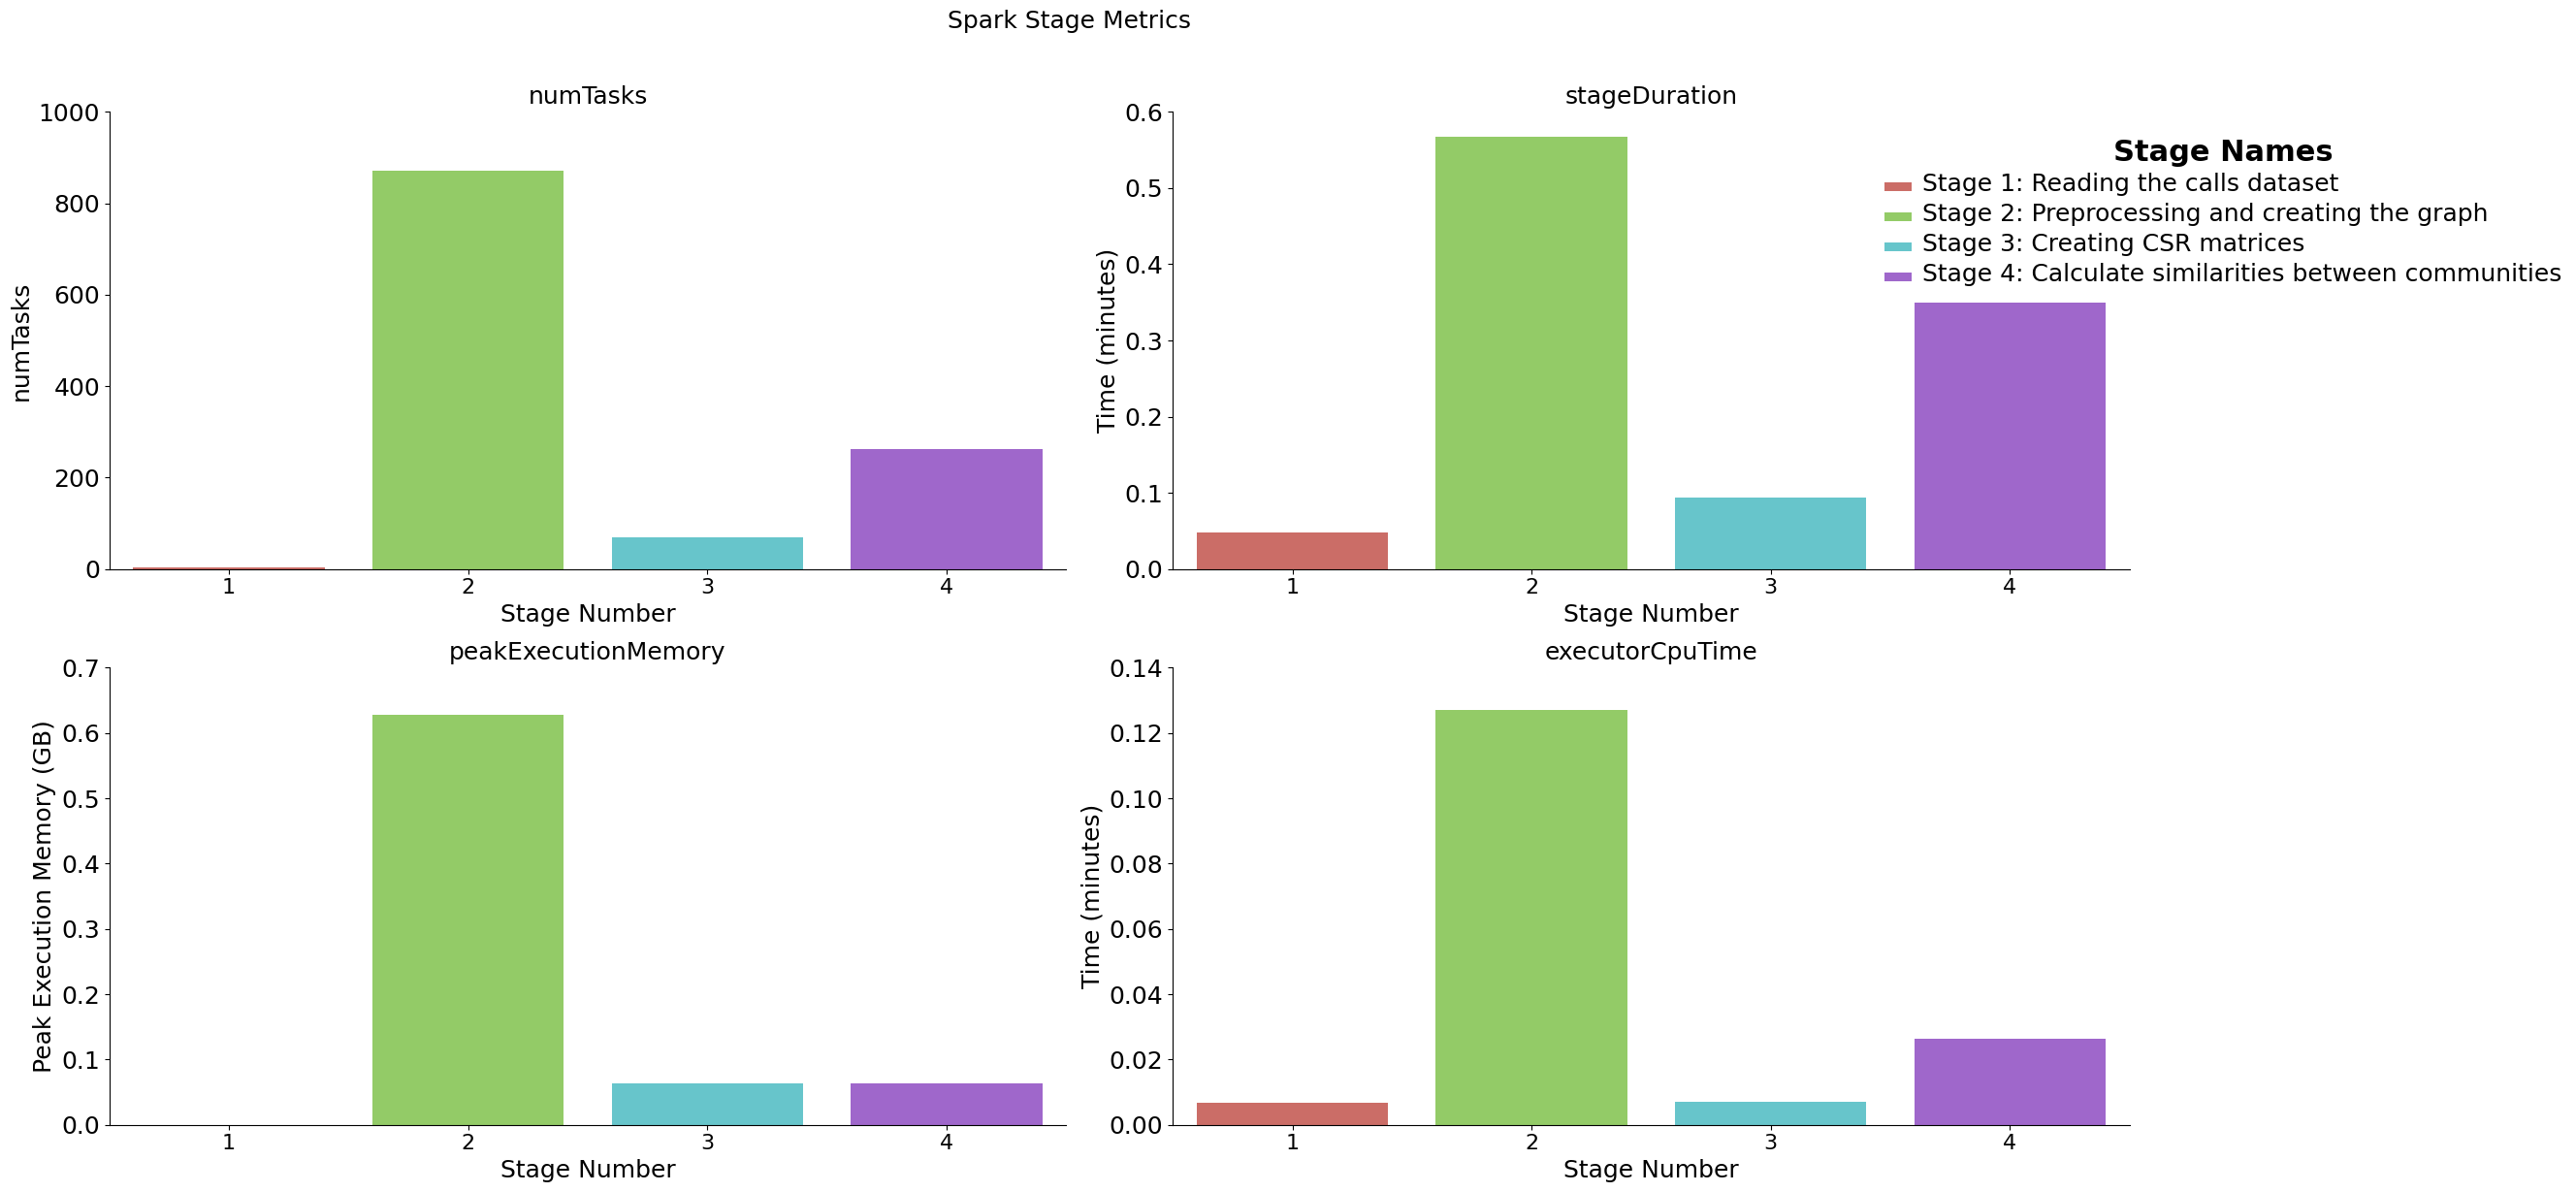

In [ ]:
# plot the resources usgae of current dataset

df_monitor = spark.read.csv("stage_metrics",  header=True)
df_monitor = df_monitor.orderBy('stage_name')
print(f"count: {df_monitor.count()}")
df_monitor.show(truncate=False)

# Convert the Spark DataFrame to a Pandas DataFrame for plotting
pdf_monitor = df_monitor.toPandas()

# Select the columns of interest for plotting
columns_of_interest = ['stage_name', 'numTasks', 'stageDuration', 'peakExecutionMemory', 'executorCpuTime']
pdf_plot = pdf_monitor[columns_of_interest].copy()  # Create a copy to avoid the warning

# Format memory and time measurements using .loc
pdf_plot.loc[:, 'peakExecutionMemory'] = pdf_plot['peakExecutionMemory'].astype(float) / (1024**3)  # Bytes to GB
pdf_plot.loc[:, 'stageDuration'] = pdf_plot['stageDuration'].astype(float) / (1000 * 60)  # ms to minutes
pdf_plot.loc[:, 'executorCpuTime'] = pdf_plot['executorCpuTime'].astype(float) / (1000 * 60)  # ms to minutes
pdf_plot.loc[:, 'numTasks'] = pdf_plot['numTasks'].astype(int)

# Extract stage numbers from stage_name
pdf_plot['stage_number'] = pdf_plot['stage_name'].apply(lambda x: int(re.search(r'\d+', x).group()))

# Melt the DataFrame for easier plotting with Seaborn
pdf_plot_melted = pd.melt(pdf_plot, id_vars=['stage_name', 'stage_number'], var_name='Metric', value_name='Value')

fig = plt.figure(figsize=(10, 8))
# Create the plot with facets, stage numbers as x-axis, and legend with full stage names
g = sns.FacetGrid(pdf_plot_melted, col='Metric',
                   height=6, aspect=1.5,
                  col_wrap=2, sharey=False, sharex=False)
g.map(sns.barplot, 'stage_number', 'Value', palette='hls', hue='stage_name',
      data=pdf_plot_melted, dodge=False)  # Pass data argument
g.set_xticklabels(pdf_plot['stage_number'].unique(), size=16)
g.set_titles("{col_name}", size=18)
g.fig.suptitle('Spark Stage Metrics', y=1.02, size=18)
g.add_legend(loc='upper right', bbox_to_anchor=(1.2, 0.92))
g.legend.set_title('Stage Names', prop={'weight': 'bold', 'size': 22})  # Add title and format it
for text in g.legend.get_texts():
    text.set_fontsize(18)  # Legend label font size# Set y-axis labels with units and add x-axis label
for ax in g.axes.flat:
    metric = ax.get_title()
    if metric == 'peakExecutionMemory':
        ax.set_ylabel('Peak Execution Memory (GB)', size=18)
    elif metric in ('stageDuration', 'executorCpuTime'):
        ax.set_ylabel('Time (minutes)', size=18)
    else:
        ax.set_ylabel(metric, size=18)

    ax.set_xlabel('Stage Number', size=18)  # Change x-axis label to "Stage Number"

g.set_yticklabels(fontsize=18)
plt.tight_layout()
plt.show()